In [102]:
import pandas as pd
from google.colab import drive

In [103]:
import matplotlib.pyplot as plt

Transferring csv data into pandas Dataframe in order to manipulate the data and calculate the AOV for the shops.

In [104]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
train = pd.read_csv("/content/drive/My Drive/test.csv")
  
temp_df = []
for row in train.itertuples(index=False):
  temp_df.append(list(row))
train = pd.DataFrame(temp_df, columns=train.columns)

In [106]:
print(train)

      order_id  shop_id  user_id  order_amount  total_items payment_method  \
0            1       53      746           224            2           cash   
1            2       92      925            90            1           cash   
2            3       44      861           144            1           cash   
3            4       18      935           156            1    credit_card   
4            5       18      883           156            1    credit_card   
...        ...      ...      ...           ...          ...            ...   
4995      4996       73      993           330            2          debit   
4996      4997       48      789           234            2           cash   
4997      4998       56      867           351            3           cash   
4998      4999       60      825           354            2    credit_card   
4999      5000       44      734           288            2          debit   

               created_at  
0     2017-03-13 12:36:56  
1     2

Here we see the different types of all of the columns in the dataframe called train, which holds all of the values of the csv file provided by task. An interesting fact is that the order_amount is type int64 and not type float64. The rest of the columns are the correct type for now.

In [107]:
print(train.dtypes)

order_id           int64
shop_id            int64
user_id            int64
order_amount       int64
total_items        int64
payment_method    object
created_at        object
dtype: object


In [108]:
print(train["order_amount"].mean())

3145.128


If we calculate the mean order_amount for all purchases made on Shopify we get $3145.13. This is very unreasonable for the average price of an order, especially when considering the 30 day time frame in which this information was collected.

Possible reasons for the high mean AOV is that there could be a mistake in the data or there can be duplicates in the data of the largest purchases, shewing the mean.

Below are different values that can be used to summarize the behaviour of an average customer placing an order.

I will now be looking for duplicates in the data by looking at what time the orders were created.

In [80]:
print(train["order_amount"].describe())

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64


In [112]:
print(train['created_at'].unique().size)

4991


In [114]:
print(train.sort_values(by="order_amount"))

      order_id  shop_id  user_id  order_amount  total_items payment_method  \
158        159       92      795            90            1    credit_card   
3871      3872       92      818            90            1          debit   
4760      4761       92      937            90            1          debit   
4923      4924       92      965            90            1    credit_card   
4932      4933       92      823            90            1    credit_card   
...        ...      ...      ...           ...          ...            ...   
2153      2154       42      607        704000         2000    credit_card   
1562      1563       42      607        704000         2000    credit_card   
1362      1363       42      607        704000         2000    credit_card   
520        521       42      607        704000         2000    credit_card   
3332      3333       42      607        704000         2000    credit_card   

              created_at  
158   2017-03-29 3:07:12  
3871  201

We can conclude that even though the largest purchases were made by the same person at the same time, they all contain different order_ids, so we can rule out that it is caused by a duplication of data. However, this does not rule out there being a mistake in the order_amount values collected in this data set.

Lets us dig deeper by seeing how we can redefine AOV for the data to make it more reasonable.

There are two ways in which we can calculate the AOV for shoes: 

*   by calculating a shop's total revenue and dividing it by the number of items soldly 
*  by calculating a customer's total expenditure and dividing it by the number of items they bought 

I will be testing out both methods in order to find the one that best fits the data and intuition.


First I will be testing out the mean by calculating a shop's total revenue and dividing it by the number of items soldly

In [122]:
revenue = train.groupby(['shop_id'])['order_amount'].sum()

In [123]:
items_sold = train.groupby(['shop_id'])['total_items'].sum()

In [124]:
mean = revenue/items_sold
print(mean)

shop_id
1      158.0
2       94.0
3      148.0
4      128.0
5      142.0
       ...  
96     153.0
97     162.0
98     133.0
99     195.0
100    111.0
Length: 100, dtype: float64


In [125]:
print(mean.sort_values())

shop_id
92        90.0
2         94.0
32       101.0
100      111.0
7        112.0
        ...   
99       195.0
89       196.0
12       201.0
42       352.0
78     25725.0
Length: 100, dtype: float64


We can see that every shop has a reasonable AOV except for shop 78, which has an AOV about 100x larger than the next highest.

I will now be looking at the mean by calculating a customer's total expenditure and dividing it by the number of items they bought, to see if it brings better results.

In [85]:
pp = train.groupby(['user_id'])['order_amount'].sum()

In [86]:
pd = train.groupby(['user_id'])['total_items'].sum()

In [87]:
ppl_avg = pp/pd
print(ppl_avg.sort_values())

user_id
973     127.583333
964     135.218750
806     135.368421
899     136.000000
706     136.625000
          ...     
775    2896.928571
855    2996.851852
962    3350.333333
766    3481.565217
878    6539.000000
Length: 301, dtype: float64


In [88]:
print(ppl_avg.mean())

400.20291584943715


In [119]:
ppl_df = ppl_avg.to_frame()
ppl_df.columns = ['AOV']
print(ppl_df)

                 AOV
user_id             
607       352.000000
700       159.666667
701       151.823529
702       155.470588
703       148.560976
...              ...
995       151.885714
996       143.567568
997      1218.166667
998       145.555556
999       153.085106

[301 rows x 1 columns]


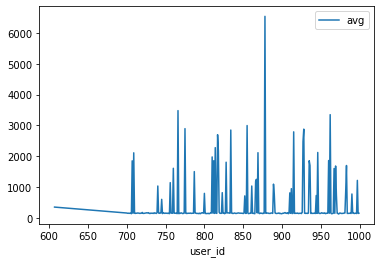

In [90]:
ppl_df.plot()
plt.show()

Despite the mean AOV by customer being reasonable at 400, I still have my doubts about this method as there is a huge deviation between the user who has the smallest mean AOV and the largest mean AOV.

As such I will return to the AOV of shops and explore the reason for the abnormal values for shop 78.


Below are all the purchases made in the shop that were collected by the dataset.

In [91]:
ff = train[train['shop_id'] == 78]
print(ff)

      order_id  shop_id  user_id  order_amount  total_items payment_method  \
160        161       78      990         25725            1    credit_card   
490        491       78      936         51450            2          debit   
493        494       78      983         51450            2           cash   
511        512       78      967         51450            2           cash   
617        618       78      760         51450            2           cash   
691        692       78      878        154350            6          debit   
1056      1057       78      800         25725            1          debit   
1193      1194       78      944         25725            1          debit   
1204      1205       78      970         25725            1    credit_card   
1259      1260       78      775         77175            3    credit_card   
1384      1385       78      867         25725            1           cash   
1419      1420       78      912         25725            1     

The problem seems to be that each purchase is in the ten thousands to hundred thousands range, which is far above the purchase values of any shoes in other shops. This leaves two possiblities, either it sells highly exclusive shoes or the prices of the shoes are inputted incorrectly. Considering the store only sells one shoe model, it is highly unlikely that they would limit their customer base by pricing their shoes so that the average order price would be 73x higher at their store than the next highest store by average order price.

We can test out the latter possibility by moving the decimal places of the prices. I choose to move the prices by two decimal places to the right, as it is most similar to the rest of the averages we calculated.

In [78]:
train.astype({'order_id': 'string', 'shop_id':'string', 'user_id' : 'string', 'order_amount': 'float'}).dtypes



order_id           string
shop_id            string
user_id            string
order_amount      float64
total_items         int64
payment_method     object
created_at         object
dtype: object

I will be creating a new column: new_order_amount. This will be used to test whether the numbers were inputted incorrectly and see if the AOV of the shop aligns with the other AOVs we previously calculated.

In [99]:
ff=ff.assign(new_order_amount=lambda g: g.order_amount/100)



In [101]:

new_total_amount= ff['new_order_amount'].sum()

total_items = ff['total_items'].sum()

new_avg_amount = new_total_amount/total_items

print(new_avg_amount)

257.25


The new average order price was inline with the rest of the stores on Shopify.

In [130]:
new_AOV = mean.to_frame()
new_AOV.columns = ['AOV']
new_AOV['AOV'] = new_AOV['AOV'].replace([25725],new_avg_amount)
print(new_AOV)

           AOV
shop_id       
1        158.0
2         94.0
3        148.0
4        128.0
5        142.0
...        ...
96       153.0
97       162.0
98       133.0
99       195.0
100      111.0

[100 rows x 1 columns]


In [132]:
from pathlib import Path  
filepath = Path('/content/drive/My Drive/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
new_AOV.to_csv(filepath)  

In [133]:
%%shell
jupyter nbconvert --to html '/content/TD3.ipynb'

[NbConvertApp] WARNING | pattern '/content/TD3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
  

CalledProcessError: ignored